<h2> Задача: </h2>

Решить уравнение Лапласа в прямоугольнике $\left[ 0 , 4\right] \times  \left[ 0 , 2\right]$

$
\begin{cases}
   \Delta \varphi (x, y)  = 0, \\
   \varphi (x, 0) = \varphi (0, y) = \varphi (4, y) = 0, \\
   \varphi (x, 2) = 10.
\end{cases}
$


Точное решение:

$
\displaystyle
\varphi\left(x, y\right) = \sum_{n = 1}^{\infty} \dfrac{20 \left(1 - (-1)^n \right)}{\pi n \left[ exp\left({-\dfrac{\pi n}{2}}\right) - exp\left({\dfrac{\pi n}{2}}\right)  \right]} \left[ exp\left({-\dfrac{\pi n}{4}} y \right) -  exp\left({\dfrac{\pi n}{4}} y \right)  \right] \sin{\left( \dfrac{\pi n}{4} x \right)}
$

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def exact_solution(x, y, row_num_el: int = 250):
    res = 0
    for n in range(1, row_num_el + 1):
        res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * y ) - np.exp( np.pi * n / 4 * y)) * np.sin(np.pi * n / 4 * x)
    return res

def print_mean_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))
    print("Mean error: ", np.mean(error_in_node))

def print_mear_rel_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        z_exact = exact_solution(x[i], y[i])
        if np.fabs(z_exact) > 1e-9:
            error_in_node.append( np.divide(np.fabs( z[i] - z_exact ) , z_exact) )
    print("Mean rel error: ", np.mean(error_in_node))



<h1> True sol

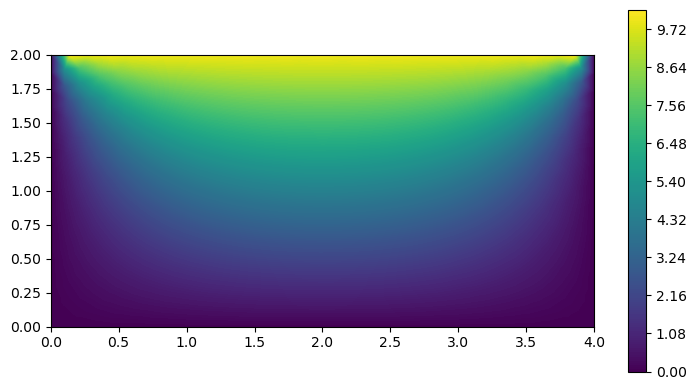

In [2]:
df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z_exact = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;
for i in range(len(df_z_exact["sol"].values)):
    df_z_exact["sol"].values[i] = exact_solution(df_x_y["x"].values[i], df_x_y["y"].values[i])


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z_exact["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + "rect_dirichlet_only_exact_sol.png", dpi = 500, transparent=True)
plt.show()


<h2> Численное решение </h2>

<h1> Rectangle domain (normal cell 0.05)

0.7056514913657771 0.7142857142857143 1.9224970600839708 1.89674353 0.025753530083970855 0.013395874885158988
3.7902107241901137 1.7968964181049911 5.044799167483403 5.08829754 0.04349837251659672 0.008622419064165813
2.0 0.2456520317761285 1.029551905839447 1.20369815 0.17414624416055302 0.1691476099192518
2.307692307692308 0.1704959243954068 0.6984510157156355 0.842866405 0.14441538928436448 0.20676523626556106
3.059294703577468 1.8000304234842883 8.41313987623576 8.41729655 0.004156673764239116 0.000494069256589956
Mean rel error:  0.14481587994476608
Mean error:  0.2624674385989901


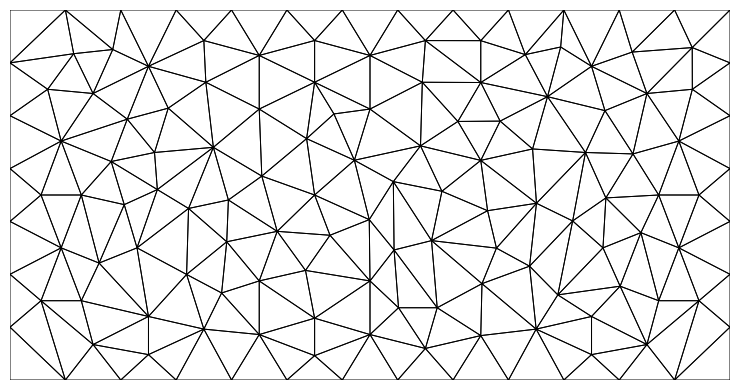

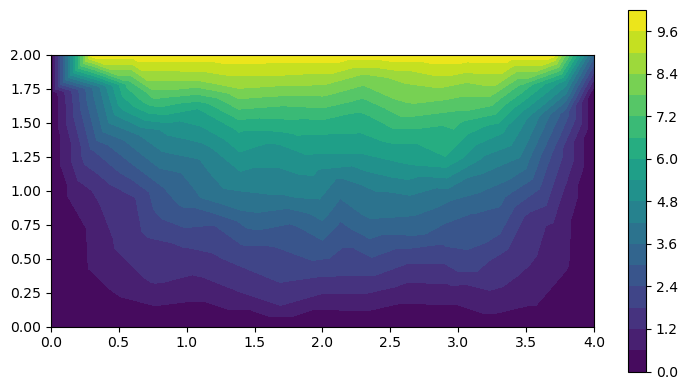

In [6]:
domain_name = "rect_dirichlet_only_005"

df_x_y = pd.read_csv("./domains/domain_2/mesh005/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005/Test_domain_2_rectangle_dirichlet_only_005_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

k = 40
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 60
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 80
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 100
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 140
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)


print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.xlim(0, 4)
plt.ylim(0, 2)
plt.axis('off')
plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)
plt.show()
plt.close()



plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 17)


plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()


<h1> Rectangle domain (small cell 0.01)

0.2336636297734494 0.8666666666666667 0.9202496748022811 1.04488683 0.1246371551977189 0.13543841265089024
3.795227342936277 0.460748764576613 0.37867336254320694 0.455975582 0.07730221945679305 0.2041395754315114
0.6635409978722687 0.8805866667523647 2.3730729347922535 2.59051092 0.21743798520774638 0.09162718179447005
0.680306357652627 0.4200839461380997 1.0369810260360595 1.08641378 0.049432753963940534 0.04766987314406424
Mean rel error:  0.07276047502218289
Mean error:  0.14219619860861768


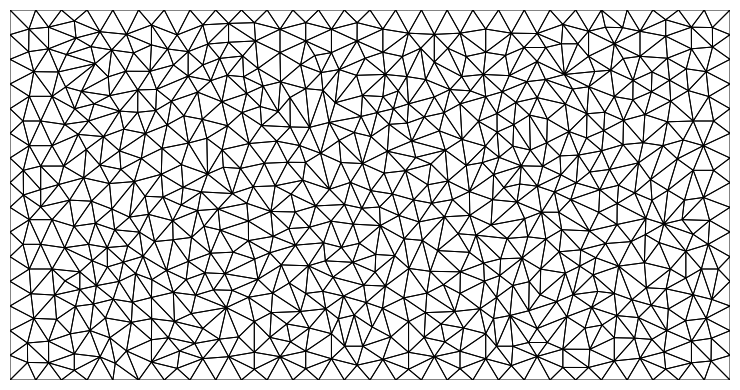

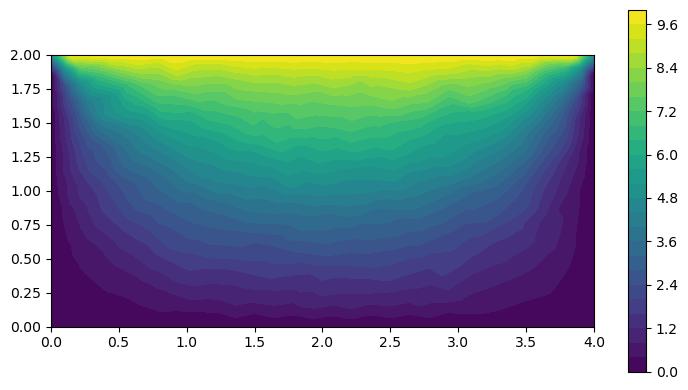

In [7]:
domain_name = "rect_dirichlet_only_001"

df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

k = 100
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 200
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 300
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 400
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.xlim(0, 4)
plt.ylim(0, 2)
plt.axis('off')
plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 25)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()

1.819289564627043 1.9018766424258933 9.417223144564742 9.45398306 0.03675991543525825 0.0039034771578577974
3.779525680767681 0.2118596556730853 0.18053212629936224 0.198592913 0.018060786700637765 0.10004195414332506
2.213288483682548 1.656466006601579 7.970691163435825 7.98153644 0.010845276564174888 0.0013606444336879753
1.5985333600489284 0.8542303745319015 3.637233199148047 3.57280551 0.0644276891480473 0.017713378719609804
Mean rel error:  0.03667891300609657
Mean error:  0.06106931316653842


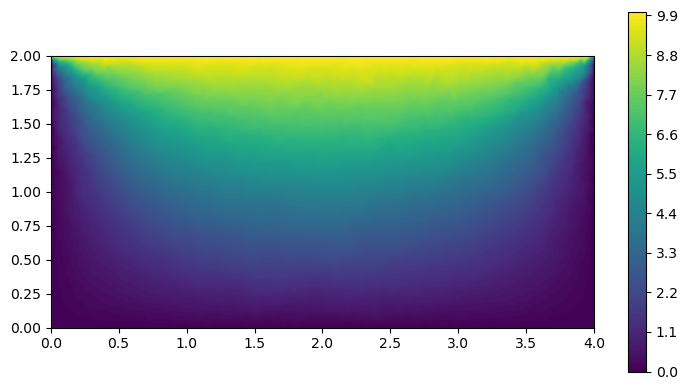

In [8]:
domain_name = "rect_dirichlet_only_0001"

df_x_y = pd.read_csv("./domains/domain_2/mesh0001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0001/Test_domain_2_rectangle_dirichlet_only_0001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


k = 1000
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 2000
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 3000
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)

k = 4000
z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
print(df_x_y["x"].values[k], df_x_y["y"].values[k], z_exact, df_z["sol"].values[k], np.fabs(z_exact - df_z["sol"].values[k]), np.fabs(z_exact - df_z["sol"].values[k]) / z_exact)


print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
# plt.xlim(0, 4)
# plt.ylim(0, 2)
# plt.axis('off')
# plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)

plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 100)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()